In [41]:
import numpy as np
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
torch.set_default_tensor_type(torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor)
print(torch.cuda.is_available())

False


In [42]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=(5, 5))
        self.conv2 = nn.Conv2d(6, 16, kernel_size=(5, 5))
        self.conv3 = nn.Conv2d(16, 60, kernel_size=(4, 4))
        
        self.bn1 = nn.BatchNorm2d(6)
        self.bn2 = nn.BatchNorm2d(16)
        self.bn3 = nn.BatchNorm2d(60)
    def forward(self, x):
        #x = x.view(-1, 1, 28, 28)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = self.bn1(x)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = self.bn2(x)
        x = F.relu(self.conv3(x))
        #x = self.bn3(x)
        return x
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(60, 16, kernel_size=(3, 3), padding=1)
        self.deconv2 = nn.ConvTranspose2d(16, 16, kernel_size=(3, 3), padding=1)
        self.deconv3 = nn.ConvTranspose2d(16, 6, kernel_size=(5, 5))
        self.deconv4 = nn.ConvTranspose2d(6, 6, kernel_size=(3, 3), padding=1)
        self.deconv5 = nn.ConvTranspose2d(6, 1, kernel_size=(5, 5))
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(6)
    def forward(self, x):
        x = F.upsample_bilinear(x, scale_factor=4)
        x = F.relu(self.deconv1(x))
        x = self.bn1(x)
        x = F.upsample_bilinear(x, scale_factor=2)
        x = F.relu(self.deconv2(x))
        x = self.bn1(x)
        x = F.relu(self.deconv3(x))
        x = self.bn2(x)
        x = F.upsample_bilinear(x, scale_factor=2)
        x = F.relu(self.deconv4(x))
        x = self.bn2(x)
        x = torch.sigmoid(self.deconv5(x))
        return x

In [43]:
def assess(model, data, labels):
    total, correct = 0.0, 0.0
    for x, y, in zip(data, labels):
        if torch.argmax(model(x)) == y:
            correct += 1
        total += 1
    return correct / total
class MNIST_Train(Dataset):
    def __init__(self, data, labels):
        self.data = np.fromfile(data, dtype=np.ubyte).reshape(-1, 1, 28, 28).astype(np.float)
        self.labels = np.fromfile(labels, dtype=np.ubyte)
        self.data = torch.tensor(self.data, dtype=torch.float) / 255
        self.label = torch.tensor(self.labels, dtype=torch.long) / 255
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        return (self.data[index], self.labels[index])
class MNIST_Test(Dataset):
    def __init__(self, data, labels):
        self.data = np.fromfile(data, dtype=np.ubyte).reshape(-1, 1, 28, 28).astype(np.float)
        self.labels = np.fromfile(labels, dtype=np.ubyte)
        self.data = torch.tensor(self.data, dtype=torch.float) / 255
        self.label = torch.tensor(self.labels, dtype=torch.long) / 255
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        return (self.data[index], self.labels[index])

In [44]:
# data_train = np.fromfile("MNIST/images_train", dtype=np.ubyte).reshape(-1, 1, 28, 28).astype(np.float)
# labels_train = np.fromfile("MNIST/labels_train", dtype=np.ubyte)
# data_test = np.fromfile("MNIST/images_test", dtype=np.ubyte).reshape(-1, 1, 28, 28).astype(np.float)
# labels_test = np.fromfile("MNIST/labels_test", dtype=np.ubyte)

# indices = np.random.choice(np.arange(len(labels_train)), len(labels_train), replace=False)
# data_train = data_train[indices]
# labels_train = labels_train[indices]

# data_train = torch.tensor(data_train, dtype=torch.float) / 255
# data_test = torch.tensor(data_test, dtype=torch.float) / 255
# labels_train = torch.tensor(labels_train, dtype=torch.long).unsqueeze(1)
# labels_test = torch.tensor(labels_test, dtype=torch.long).unsqueeze(1)
# #plt.imshow(data_train[34], cmap='gray')

train_dataset = MNIST_Train("MNIST/images_train", "MNIST/labels_train")
test_dataset = MNIST_Test("MNIST/images_test", "MNIST/labels_test")
dataloader = DataLoader(train_dataset, batch_size=128,
                        shuffle=True)

In [52]:
encoder = Encoder()
decoder = Decoder()
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)

128
tensor(0.7183, grad_fn=<BinaryCrossEntropyBackward>)


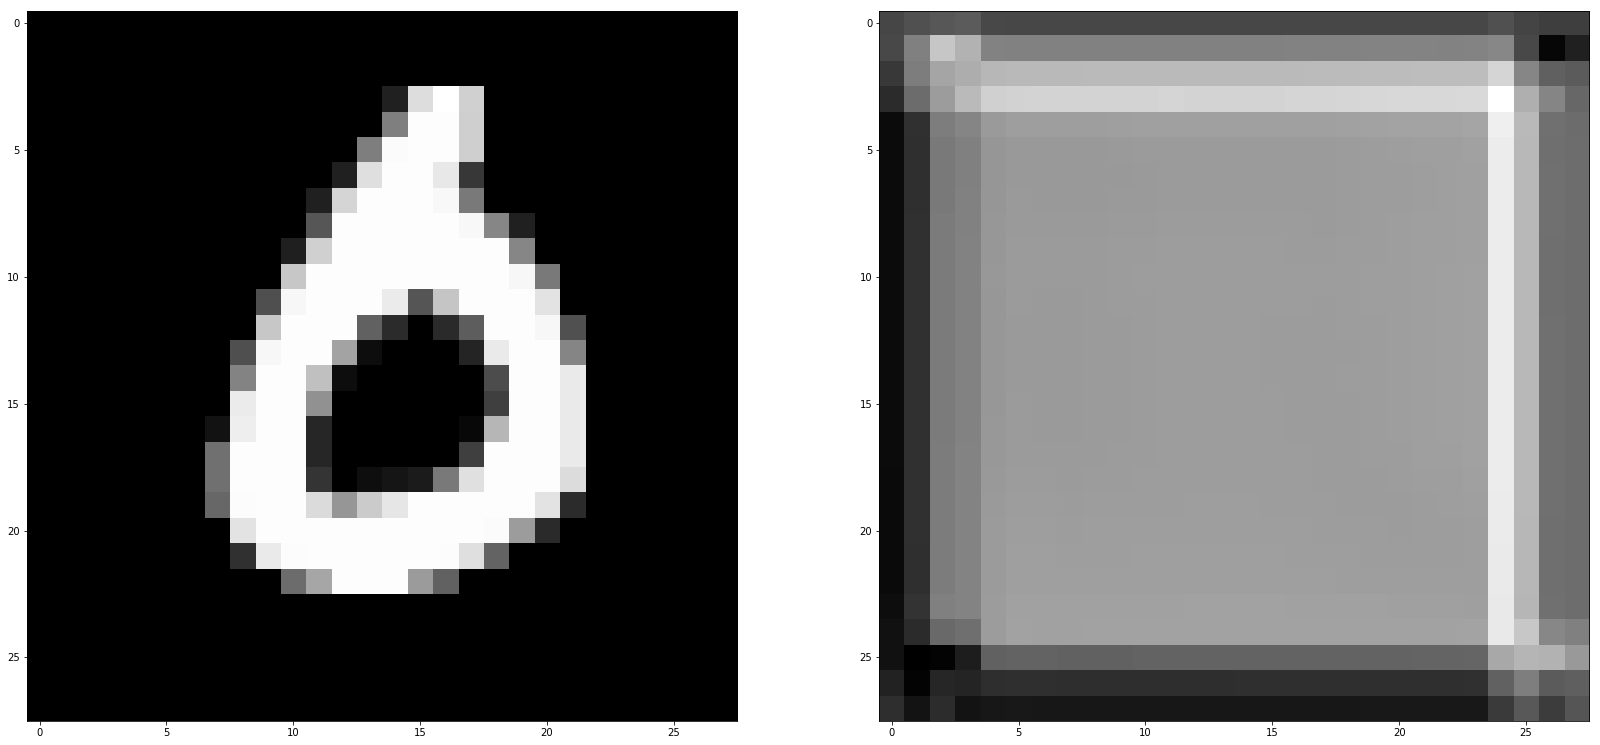

128
tensor(0.7096, grad_fn=<BinaryCrossEntropyBackward>)


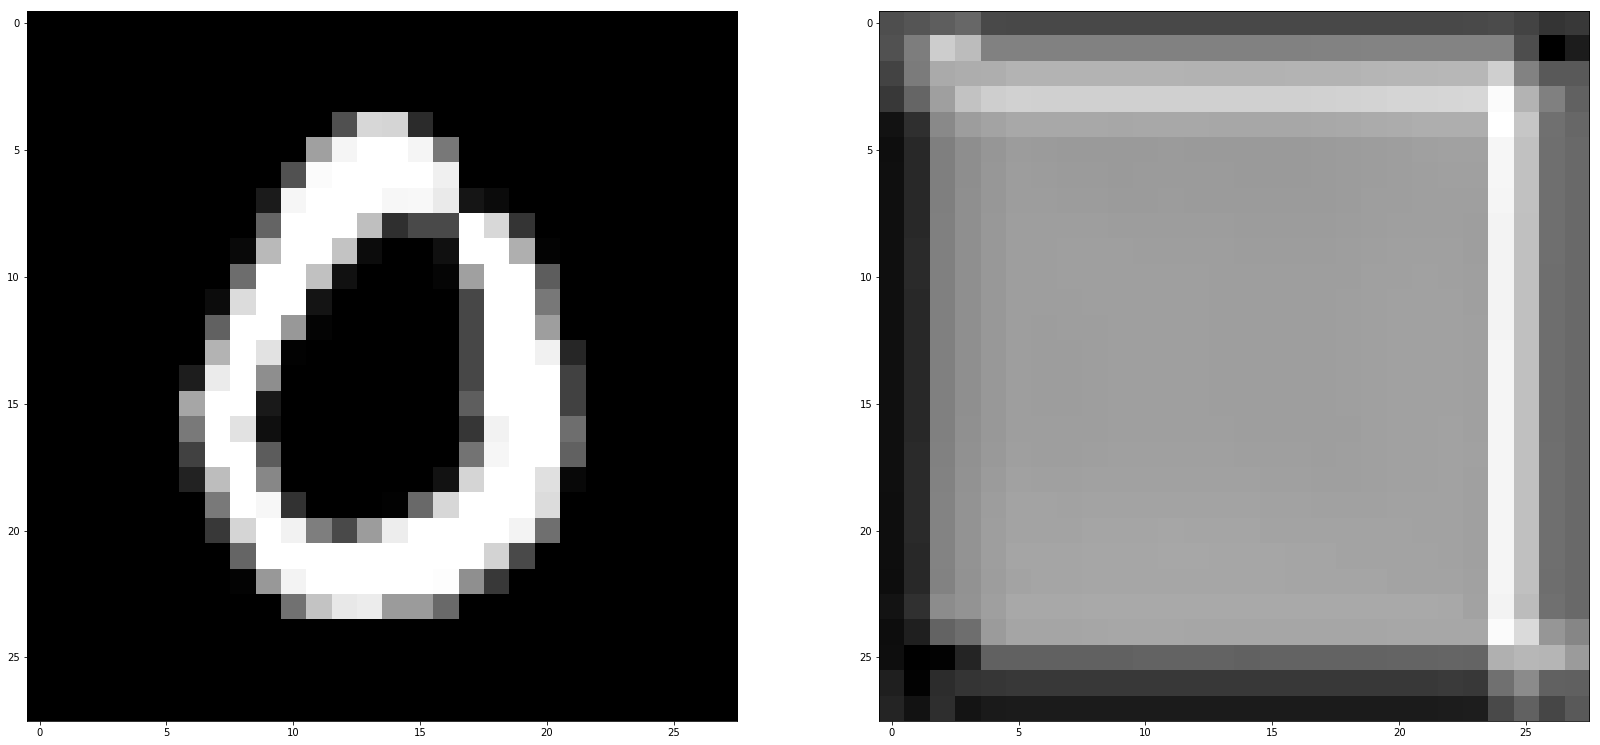

128
tensor(0.7023, grad_fn=<BinaryCrossEntropyBackward>)


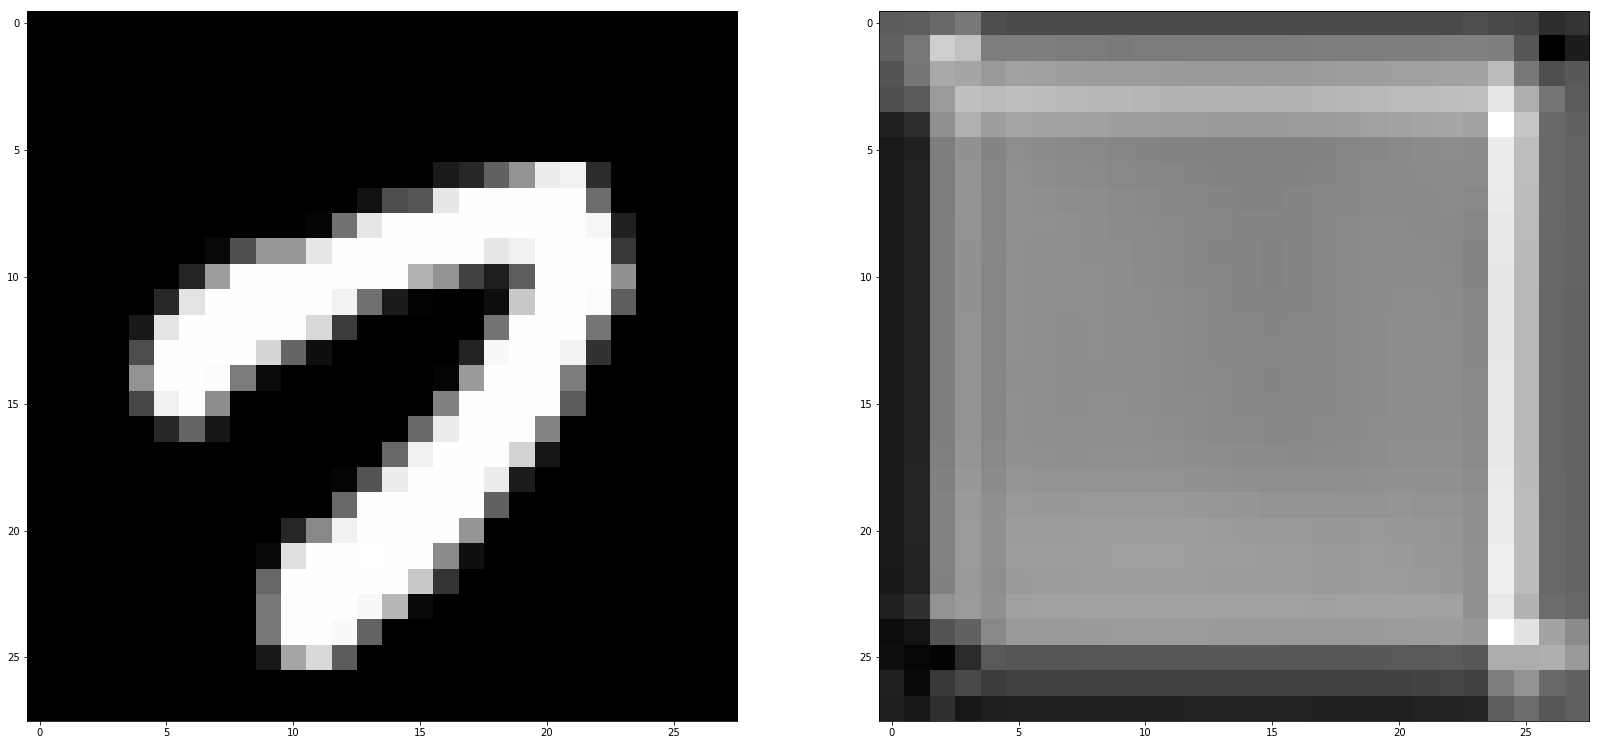

128
tensor(0.6984, grad_fn=<BinaryCrossEntropyBackward>)


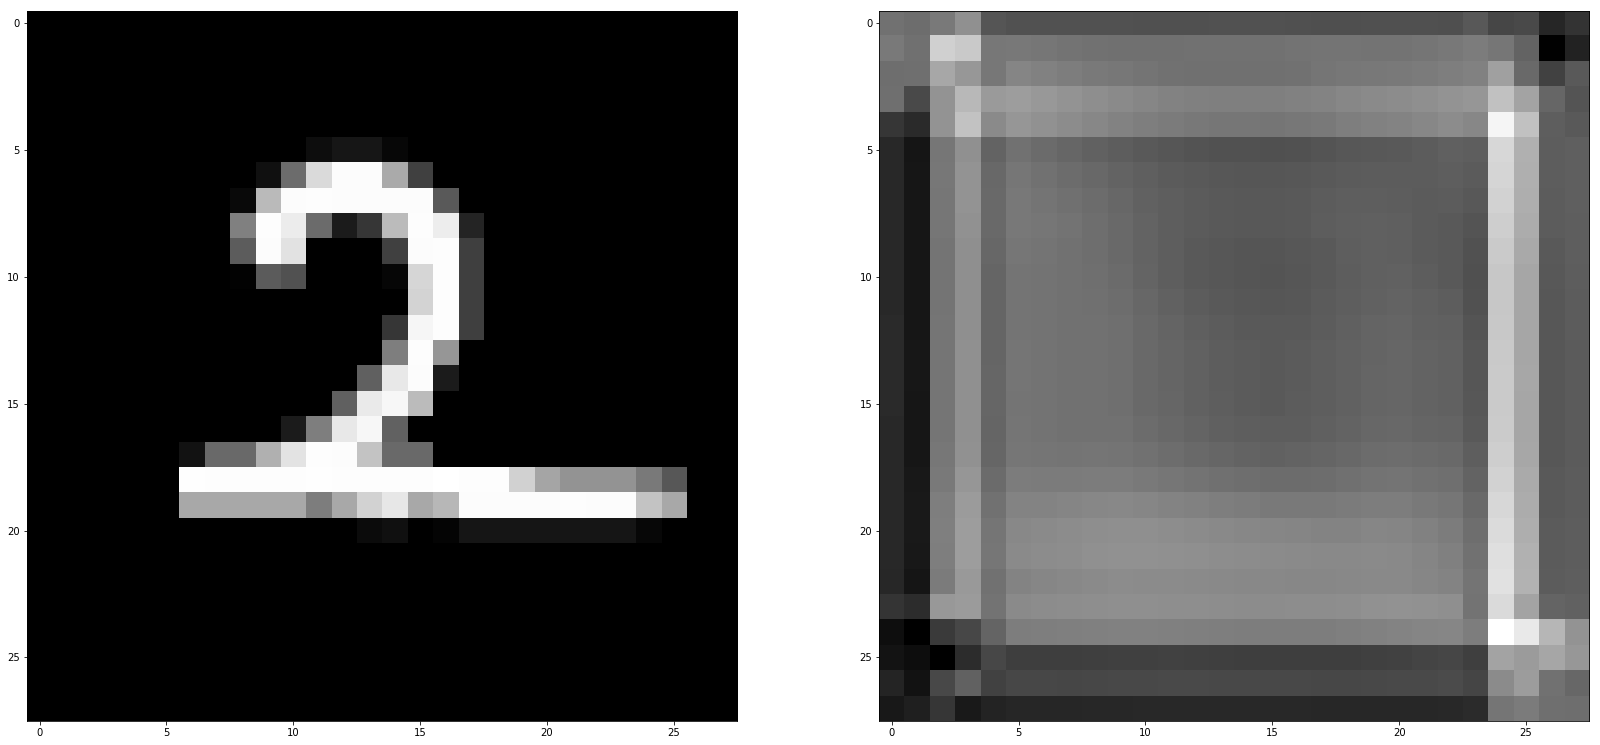

128
tensor(0.6934, grad_fn=<BinaryCrossEntropyBackward>)


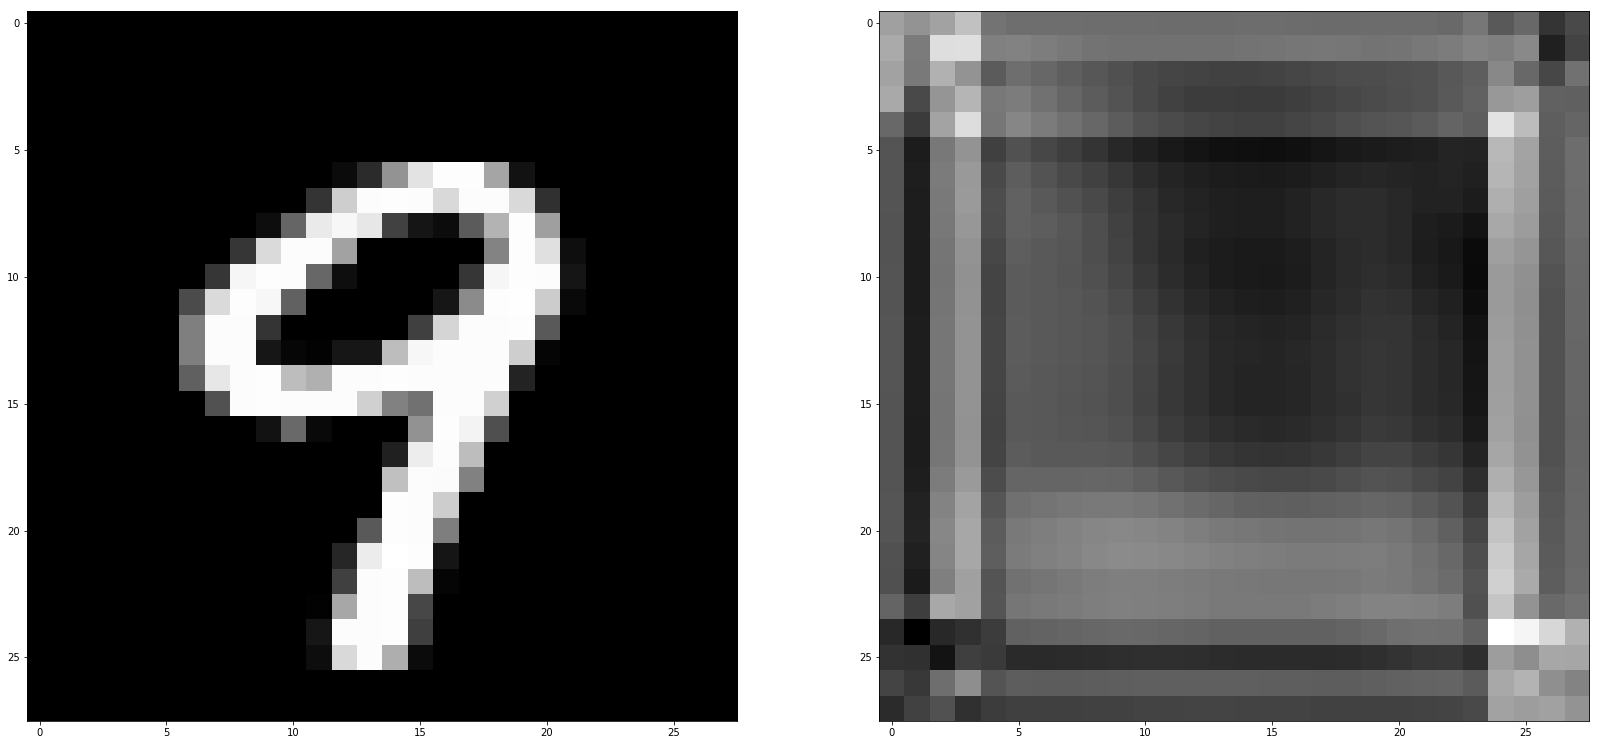

128
tensor(0.6879, grad_fn=<BinaryCrossEntropyBackward>)


KeyboardInterrupt: 

In [53]:
epochs = 50
encoder.train()
decoder.train()
for epoch in range(epochs):
    for count, (x, _label) in enumerate(dataloader):
        print(len(x))
        optimizer.zero_grad()
        z = encoder(x)
        y = decoder(z)
        criterion = nn.BCELoss()
        loss = criterion(y.view(-1, 28, 28), x.view(-1, 28, 28))
        loss.backward()
        optimizer.step() 
        if count % 1 == 0:
            print(loss)
            index = np.random.randint(len(data_test))
            encoder.eval()
            decoder.eval()
            z = encoder(test_dataset[index][0].view(-1, 1, 28, 28))
            y = decoder(z)
            y_vis = y.detach().cpu().numpy().reshape(28,28)
            x_vis = test_dataset[index][0].cpu().numpy().reshape(28,28)

            encoder.train()
            decoder.train()

            fig = plt.figure(figsize=(28,28))
            fig.add_subplot(1, 2, 1)
            plt.imshow(x_vis, cmap='gray')
            fig.add_subplot(1, 2, 2)
            plt.imshow(y_vis, cmap='gray')
            plt.show()
    torch.save(encoder.state_dict(), "encoder")
    torch.save(decoder.state_dict(), "decoder")